In [1]:
import os
import torch
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import utils
from train_models import epoch_test
from networks import MaskCore
from loaddata import Loaders
import seaborn as sns
sns.set_theme()

In [2]:
save_fig_folder = 'figs'

if not os.path.exists(save_fig_folder):
    os.makedirs(save_fig_folder)

### Masks

In [3]:
architecture = 'resnet'
transforms = ['n', 'adv', 'sn', 'tn', 'rn']

pts = [f'trained_masks/{architecture}_mask_{t}.pt' for t in transforms]

masks = utils.get_masks(pts)
mask_diffs = utils.get_mask_diffs(masks, [[1, 0], [2, 0], [3, 0], [4, 0]])
titles = ['(A)', '(B)', '(C)', '(D)', '(E)', '(B-A)', '(C-A)', '(D-A)', '(E-A)']
figsize=(16, 4) 
savename=save_fig_folder + f"/{architecture}_standard_vs_transforms.png"
mask_colormap='turbo'
diff_colormap='coolwarm'

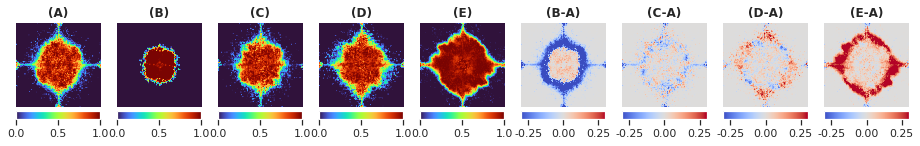

In [4]:
fig, axs = plt.subplots(
    1, len(masks) + len(mask_diffs),
    figsize=figsize
)
plt.subplots_adjust(hspace=0.035)
for i, ax in enumerate(axs[:len(masks)]):
    im = ax.imshow(
        masks[i],
        cmap=mask_colormap,
        vmin=0,
        vmax=1.0
    )
    ax.axis("off")
    ax.set_title(titles[i], weight='bold')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='10%', pad=0.05)
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')

for i, ax in enumerate(axs[len(masks):len(masks)+len(mask_diffs)]):
    im = ax.imshow(
        mask_diffs[i],
        cmap=diff_colormap,
        vmin=-0.3,
        vmax=0.3
    )
    ax.axis("off")
    ax.set_title(titles[i+len(masks)], weight='bold')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='10%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='horizontal', format="%.2f")

plt.savefig(savename, dpi=300, bbox_inches='tight')
plt.show()

### Mask Performance

In [5]:
pts = [
    [f'trained_models/{architecture}_basemodel_{t}.pt', f'trained_masks/{architecture}_mask_{t}.pt'] for t in transforms
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = torch.nn.CrossEntropyLoss()
loader = Loaders(batch_size=128, num_workers=3).testloader()

clean_accuracies = np.zeros(len(pts))
masked_accuracies = np.zeros(len(pts))

for i in tqdm(range(len(pts))):
    clean_model = MaskCore(
        mask_size=(128, 128), 
        num_classes=5, 
        architecture=architecture,
        pretrained_model=pts[i][0]
    )
    clean_model = clean_model.to(device)
    clean_accuracies[i] = epoch_test(
        clean_model, 
        loader,
        criterion, 
        device
    ).accuracy
    del clean_model
    
    masked_model = MaskCore(
        mask_size=(128, 128), 
        num_classes=5, 
        architecture=architecture,
        pretrained_model=pts[i][0], 
        pretrained_mask=pts[i][1]
    )    
    masked_accuracies[i] = epoch_test(
        masked_model.to(device), 
        loader,
        criterion,
        device
    ).accuracy
    del masked_model

100%|██████████| 5/5 [01:52<00:00, 22.54s/it]


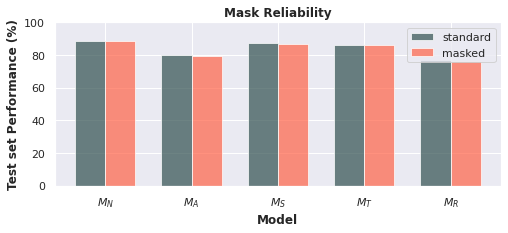

In [6]:
width = 0.35
ind = np.arange(len(pts))
ticks = ['$M_{N}$', '$M_{A}$', '$M_{S}$', '$M_{T}$', '$M_{R}$']

plt.figure(figsize=(8, 3))

plt.bar(x=ind, height=clean_accuracies, width=width, color='Darkslategray', alpha=0.7, label='standard')
plt.bar(x=ind + width, height=masked_accuracies, width=width, color='tomato', alpha=0.7, label='masked')
plt.ylim([0, 100])
plt.ylabel('Test set Performance (%)', weight='bold')
plt.xlabel("Model", weight='bold')
plt.xticks(ind + width/2, ticks)
plt.title('Mask Reliability', weight='bold')
plt.legend(loc='best')

plt.savefig(f'figs/{architecture}_mask_reliability.png', dpi=300, bbox_inches='tight')
plt.show()

### Energies

In [7]:
colormap = "magma"
sectors = 64
eps = 1e-3
cm = sns.color_palette(colormap, sectors)

pts_pairs = {
    t: [f'trained_masks/{architecture}_mask_n.pt', f'trained_masks/{architecture}_mask_{t}.pt'] for t in transforms[1:]
}

abbr = {
    '0': ['A', 'N'],
    '1': ['S', 'N'],
    '2': ['T', 'N'],
    '3': ['R', 'N'],
}

radial = []
angular = []

for key in pts_pairs.keys():
    M = utils.get_masks(pts_pairs[key])
    R, A = [], []
    for i in range(len(M)):
        r, a = utils.energies(M[i], sectors)
        R.append(r)
        A.append(a)

    radial.append(R[1] - R[0])
    angular.append(A[1] - A[0])
    
rsectors, asectors = utils.get_sectors(sectors)

rmin, rmax = rsectors.min(), rsectors.max() 
amin, amax = asectors.min(), asectors.max()

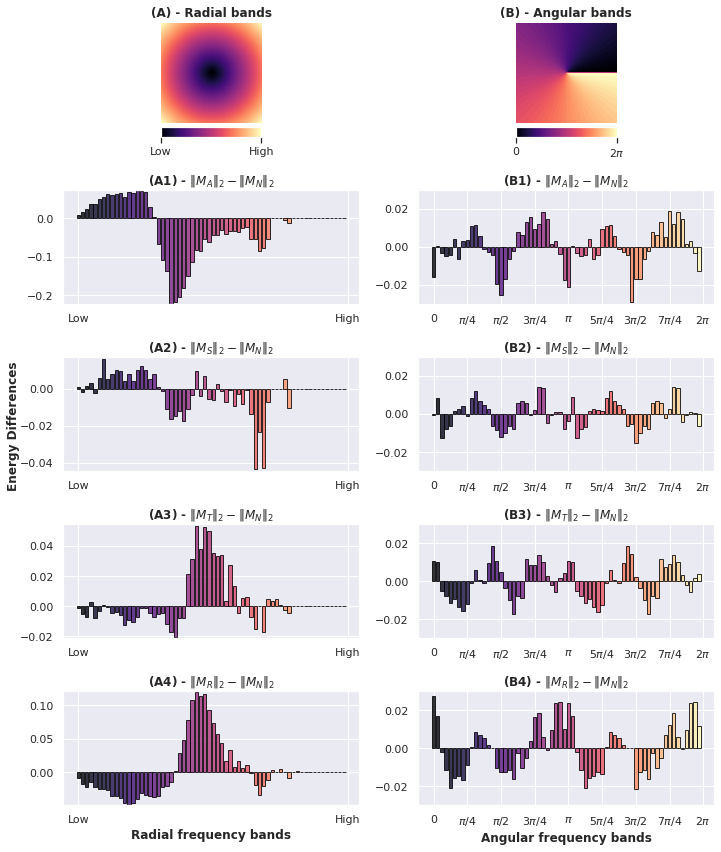

In [8]:
fig, axs = plt.subplots(5, 2, figsize=(10, 12))

im = axs[0, 0].imshow(rsectors, cmap=colormap)
axs[0, 0].set_title('(A) - Radial bands', weight='bold')
axs[0, 0].axis('off')

divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('bottom', size='10%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[rmin, rmax])
cbar.ax.set_xticklabels(['Low', 'High'])

im = axs[0, 1].imshow(asectors, cmap=colormap)
axs[0, 1].set_title('(B) - Angular bands', weight='bold')
axs[0, 1].axis('off')

divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('bottom', size='10%', pad=0.05)
cbar = fig.colorbar(im, cax=cax, orientation='horizontal', ticks=[rmin, rmax])
cbar.ax.set_xticklabels(['0', '$2\pi$'])

for i in range(4):
    axs[i+1, 0].bar(
        np.arange(len(radial[i])),
        radial[i],
        align='center',
        alpha=0.8,
        edgecolor='black',
        color=cm
    )
    axs[i+1, 0].set_xticks([0, len(radial[i])])
    axs[i+1, 0].set_xticklabels(['Low', 'High'])
    axs[i+1, 0].set_ylim([min(radial[i]) - eps, max(radial[i]) + eps])
    axs[i+1, 0].set_title(
        f'(A{i+1}) - ' + f'$\Vert M_{abbr[str(i)][0]}\Vert_{2} - \Vert M_{abbr[str(i)][1]}\Vert_{2}$', 
        weight='bold'
    )
 
    axs[i+1, 1].bar(
        np.arange(len(angular[i])),
        angular[i],
        align='center',
        alpha=0.8,
        edgecolor='black',
        color=cm
    )
    axs[i+1, 1].set_xticks(np.linspace(0, len(angular[i]), 9))
    axs[i+1, 1].set_xticklabels(
        [
            '0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$', 
            '$5\pi/4$', '$3\pi/2$', '$7\pi/4$', '$2\pi$'
        ]
    )
    axs[i+1, 1].set_ylim([-0.03, 0.03])
    axs[i+1, 1].set_title(
        f'(B{i+1}) - ' + f'$\Vert M_{abbr[str(i)][0]}\Vert_{2} - \Vert M_{abbr[str(i)][1]}\Vert_{2}$', 
        weight='bold'
    )

axs[4, 0].set_xlabel("Radial frequency bands", weight='bold')
axs[4, 1].set_xlabel("Angular frequency bands", weight='bold')

fig.text(0.0, 0.5, 'Energy Differences', va='center', rotation='vertical', weight='bold')
plt.tight_layout()
plt.savefig(f'figs/{architecture}_energies.png', dpi=300, bbox_inches='tight')
plt.show()